In [2]:
from pathlib import Path
import menpo.io as mio
from menpo.visualize import print_progress

path_to_300w = Path('300W/')

def preprocess_img(img):
    img = img.crop_to_landmarks_proportion(0.1)
    if img.n_channels == 3:
        img = img.as_greyscale(mode='luminosity')
    return img

training_images = [preprocess_img(i) for i in mio.import_images(path_to_300w / '01_Indoor', verbose=True)]
training_images += [preprocess_img(i) for i in mio.import_images(path_to_300w / '02_Outdoor', verbose=True)]

Found 300 assets, index the returned LazyList to import.
Found 300 assets, index the returned LazyList to import.


In [3]:
from menpofit.aam import HolisticAAM
from menpo.feature import no_op

# build AAM
aam = HolisticAAM(
    training_images,
    group='PTS',
    verbose=True,
    holistic_features=no_op, 
    diagonal=120, 
    scales=1
)

- Computing reference shape                                                     Computing batch 0
- Building modelsges size: [==========] 100% (600/600) - done.                  
  - Warping images: [=         ] 12% (72/600) - 00:00:00 remaining              

/Users/amit/anaconda3/envs/conda_env/lib/python3.7/site-packages/menpofit/builder.py:338: MenpoFitModelBuilderWarning: The reference shape passed is not a TriMesh or subclass and therefore the reference frame (mask) will be calculated via a Delaunay triangulation. This may cause small triangles and thus suboptimal warps.
  MenpoFitModelBuilderWarning)


  - Doneding appearance model                                                   
                                                                       

In [6]:
from menpofit.aam import LucasKanadeAAMFitter

# define Lucas-Kanade based AAM fitter
fitter = LucasKanadeAAMFitter(aam, n_shape=0.9, n_appearance=0.9)

In [13]:
from menpofit.fitter import noisy_shape_from_bounding_box

test_img = mio.import_image(path_to_300w / '01_Indoor/indoor_004.png')
gt_s = test_img.landmarks['PTS']
initial_s = noisy_shape_from_bounding_box(gt_s, gt_s.bounding_box())
fr = fitter.fit_from_shape(test_img, initial_s, gt_shape=gt_s)
print(fr)

Fitting result of 68 landmark points.
Initial error: 0.0505
Reconstructed initial error: 0.0517
Final error: 0.0238


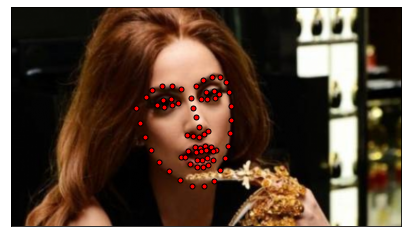

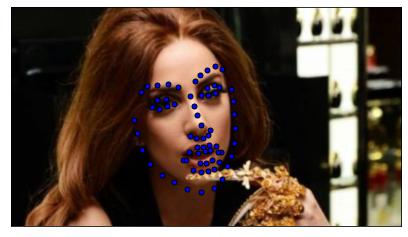

In [14]:
fr.image.view(new_figure=True);
fr.final_shape.view();

fr.image.view(new_figure=True);
fr.initial_shape.view(marker_face_colour='blue');

In [15]:
from menpodetect.dlib.detect import DlibDetector
import dlib

ff_detector = dlib.get_frontal_face_detector()
bboxes = DlibDetector(ff_detector)(test_img)

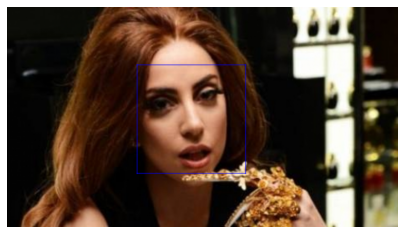

In [16]:
test_img.rasterize_landmarks(group='dlib_0').view()

In [17]:
fr = fitter.fit_from_bb(test_img, bboxes[0], max_iters=100)

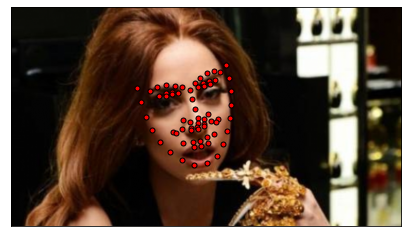

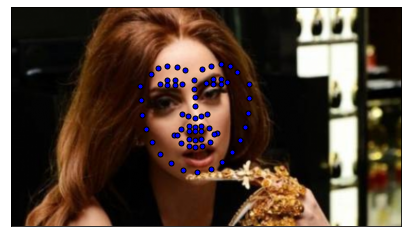

In [18]:
fr.image.view(new_figure=True);
fr.final_shape.view();

fr.image.view(new_figure=True);
fr.initial_shape.view(marker_face_colour='blue');